In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
sys.path.append('../deep_boltzmann')

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [13]:
rcParams.update({'font.size': 16})

In [14]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from deep_boltzmann.models import MuellerPotential
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [16]:
xgrid = np.linspace(-1.5, 1.0, 100)
ygrid = np.linspace(-0.5, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

In [17]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [18]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [19]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [20]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [21]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [22]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [23]:
def getx(x):
    return x[:, 0]
def gety(x):
    return x[:, 1]

Plotting functions
-----

In [24]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [25]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [26]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

Mueller potential
---

In [27]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

In [28]:
params = MuellerPotential.params_default.copy()
params['k'] = 0.1
params['dim'] = 2
mueller = MuellerPotential(params=params)
#plt.figure(figsize=(5,5))
#double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [29]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4), orientation='vertical'):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    return cbar
    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')    #plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')

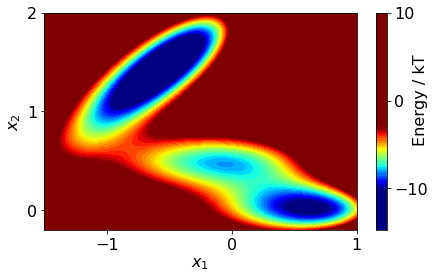

In [30]:
plot_potential(labels=True, cbar=True)

In [31]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [32]:
nsteps = 1000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

In [33]:
x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

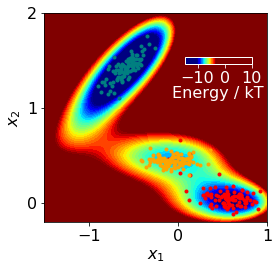

In [34]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/mueller/potential_horizontal.pdf', bbox_inches='tight', transparent=True)

In [35]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

Training
-------

In [36]:
epochsZ = 200
epochsE = 500
temperature = 1.0
explore = 1.0
batch_size_KL = 1000
batch_size_ML = 128

In [37]:
bg = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0
Instructions for updating:
Colocations handled automatically by placer.


In [38]:
hist = bg.train_ML(x, xval=xval, epochs=epochsZ, batch_size=batch_size_ML, std=1.0, verbose=0,
                   return_test_energies=True)
hist2 = bg.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=batch_size_KL, std=1.0,
                          weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                          weight_RCEnt=1.0, rc_func=gety, rc_min=-0.1, rc_max=1.7,
                          temperature=temperature, explore=explore, verbose=0, return_test_energies=True)

Instructions for updating:
Use tf.cast instead.


(<Figure size 360x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000158246080F0>,
       dtype=object))

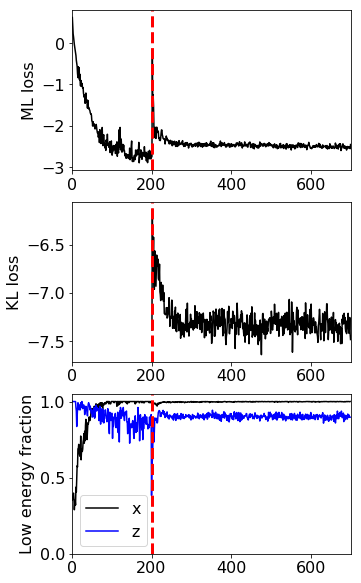

In [39]:
zener = energy_cut_z(mueller.dim, nstd=3)
plot_convergence(hist, hist2, 0, 2)
#plt.savefig(paper_dir + 'figs/mueller/training_convergence_KLRC.pdf', bbox_inches='tight', transparent=True)

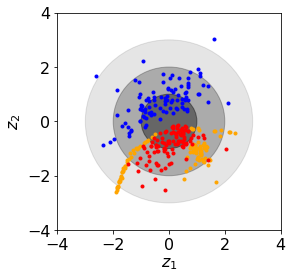

In [40]:
# Plot z distribution
z_left = bg.transform_xz(traj_left)
z_int = bg.transform_xz(x_intermediate)
z_right = bg.transform_xz(traj_right)
plt.figure(figsize=(4, 4))
plt.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=6, color='blue')
plt.plot(z_int[:, 0], z_int[:, 1], linewidth=0, marker='.', markersize=6, color='orange')
plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=6, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
#plt.savefig(paper_dir + 'figs/mueller/zdist.pdf', bbox_inches='tight', transparent=True)

In [41]:
_, sample_x, _, sample_e, sample_logw = bg.sample(temperature=1.0, nsample=100000)

(-0.2, 2.0)

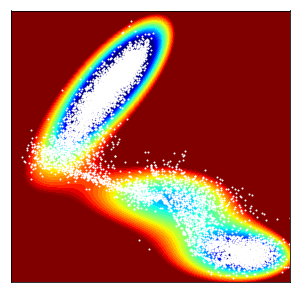

In [42]:
plot_potential(labels=False, cbar=False, figsize=(5, 5))
plt.plot(sample_x[::10, 0], sample_x[::10, 1], color='white', linewidth=0, marker='.', markersize=2)
plt.xlim(-1.5, 1.0)
plt.ylim(-0.2, 2.0)
#plt.savefig(paper_dir + 'figs/mueller/sample_on_pot_horizontal.pdf', bbox_inches='tight')

In [43]:
# long reference MD 
sampler.reset(x0_left)
sampler.run(100000)
traj_left_ref = sampler.traj.copy()
sampler.reset(x0_right)
sampler.run(100000)
traj_right_ref = sampler.traj.copy()
x_ref=np.vstack([traj_left_ref, traj_right_ref])

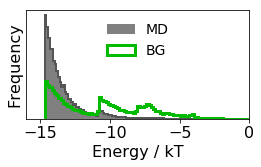

In [44]:
plt.figure(figsize=(4,2))
nsample = 100000
energy_md = mueller.energy(x_ref)
plt.hist(energy_md, 100, density=True, color='grey', linewidth=1, label='MD');
plt.hist(energy_md, 100, density=True, histtype='step', color='#555555', linewidth=2);
plt.hist(sample_e, 200, density=True, histtype='step', color='#00BB00', linewidth=3, label='BG');
plt.xlim(-16, 0)
plt.yticks([]);
plt.xlabel('Energy / kT')
plt.ylabel('Frequency')
plt.legend(ncol=1, loc=9, fontsize=14, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/hist_sample_energy.pdf', bbox_inches='tight', transparent=True)

In [45]:
# Free energy:
proj_dir = np.array([[0.7],[-0.7]])
proj = sample_x.dot(proj_dir)

No handles with labels found to put in legend.


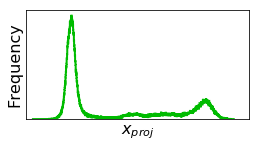

In [46]:
plt.figure(figsize=(4,2))
nsample = 100000
plt.hist(proj[:, 0], 1000, histtype='step', color='#00BB00', linewidth=2);
plt.xlim(-2, 1)
plt.yticks([]);
plt.xlabel('$x_{proj}$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/hist_samplex.pdf', bbox_inches='tight', transparent=True)

In [47]:
# Reference calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
xwild_proj = xwild.dot(proj_dir)

Text(0,0.5,'Free energy / kT')

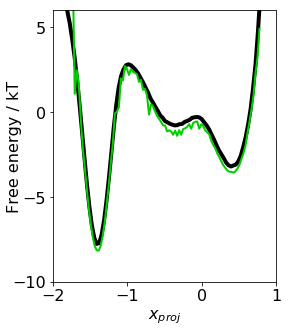

In [48]:
plt.figure(figsize=(4, 5))
hist, bin_edges = np.histogram(proj[:, 0], bins=100, weights=np.exp(sample_logw-sample_logw.max()))
bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_values_ref, -np.log(hist_ref), color='black', linewidth=4)
plt.plot(bin_values, -np.log(hist)-1.2, color='#00CC00', linewidth=2)
plt.xlim(-2, 1)
plt.ylim(-10, 6)
plt.yticks([-10, -5, 0, 5])
plt.xlabel('$x_{proj}$')
plt.ylabel('Free energy / kT', labelpad=-10)
#plt.savefig(paper_dir + 'figs/mueller/free_energy.pdf', bbox_inches='tight', transparent=True)

In [49]:
xpaths = []
for i in range(10):
    x1 = traj_left[np.random.randint(100)] 
    x2 = traj_right[np.random.randint(100)]
    xpaths.append(latent_interpolation(bg, x1, x2, nstep=1000))

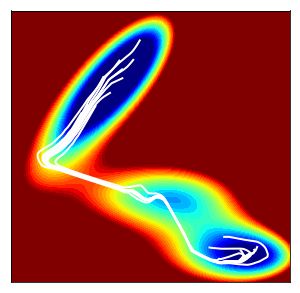

In [50]:
plot_potential(cbar=False, figsize=(5, 5))
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')
for xpath in xpaths:
    plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')
#plt.savefig(paper_dir + 'figs/mueller/paths.pdf', bbox_inches='tight')

BG without RC
-----

In [51]:
bg_noRC = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
                 nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [52]:
hist_noRC = bg_noRC.train_ML(x, xval=xval, epochs=epochsZ, batch_size=128, std=1.0, verbose=0,
                             return_test_energies=True)
hist2_noRC = bg_noRC.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=2048, std=1.0,
                                    weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                                    temperature=temperature, explore=explore, verbose=0,
                             return_test_energies=True)

../deep_boltzmann\deep_boltzmann\models\mueller_potential.py:44: RuntimeWarning: overflow encountered in multiply
  self.cc[j] * (x2 - self.YY[j])**2)


(<Figure size 360x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001584305E470>,
       dtype=object))

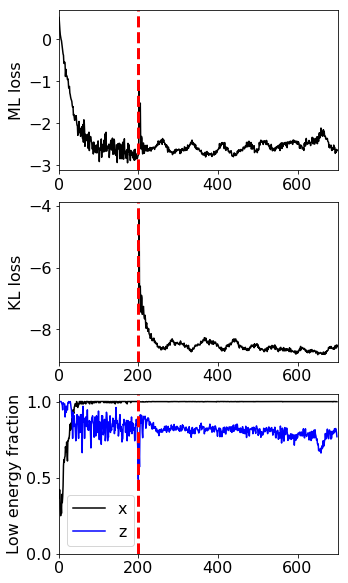

In [53]:
zener = energy_cut_z(mueller.dim, nstd=3)
plot_convergence(hist_noRC, hist2_noRC, 0, 2)
#plt.savefig(paper_dir + 'figs/mueller/training_convergence_KLML.pdf', bbox_inches='tight', transparent=True)

NameError: name 'sample_x_noRC' is not defined

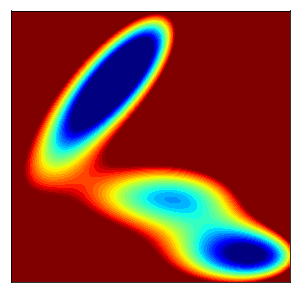

In [54]:
plot_potential(labels=False, cbar=False, figsize=(5, 5))
plt.plot(sample_x_noRC[::10, 0], sample_x_noRC[::10, 1], color='white', linewidth=0, marker='.', markersize=2)
plt.xlim(-1.5, 1.0)
plt.ylim(-0.2, 2.0)
#plt.savefig(paper_dir + 'figs/mueller/sample_on_pot_horizontal.pdf', bbox_inches='tight')

In [ ]:
_, sample_x_noRC, _, sample_e_noRC, sample_logw_noRC = bg_noRC.sample(temperature=1.0, nsample=100000)

In [ ]:
plt.figure(figsize=(4,2))
nsample = 100000
energy_md = mueller.energy(x_ref)
plt.hist(energy_md, 100, density=True, color='grey', linewidth=1, label='MD');
plt.hist(energy_md, 100, density=True, histtype='step', color='#555555', linewidth=2);
plt.hist(sample_e_noRC, 200, density=True, histtype='step', color='#00BB00', linewidth=3, label='KL + ML');
plt.hist(sample_e, 200, density=True, histtype='step', color='#FF6600', linewidth=3, label='KL + RC');
plt.xlim(-16, 0)
plt.yticks([]);
plt.xlabel('Energy / kT')
plt.ylabel('Frequency')
#plt.legend(ncol=1, loc=9, fontsize=14, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/hist_sample_energy_horizontal.pdf', bbox_inches='tight', transparent=True)

In [ ]:
xproj = x.dot(proj_dir)

In [ ]:
proj_noRC = sample_x_noRC.dot(proj_dir)

In [ ]:
plt.figure(figsize=(4,2))
nsample = 100000
plt.hist(proj_noRC[:, 0], 1000, histtype='step', color='#00BB00', linewidth=2);
plt.hist(proj[:, 0], 1000, histtype='step', color='#FF6600', linewidth=2);
plt.xlim(-2, 1)
plt.yticks([]);
plt.xlabel('$x_{proj}$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
#plt.savefig(paper_dir + 'figs/mueller/hist_samplex.pdf', bbox_inches='tight', transparent=True)

In [ ]:
plt.figure(figsize=(4, 5))
hist_noRC, bin_edges = np.histogram(proj_noRC[:, 0], bins=100, weights=np.exp(sample_logw_noRC-sample_logw_noRC.max()))
hist_noRC[18:67] = np.nan  # eliminate low-weight samples
bin_values_noRC = 0.5*(bin_edges[:-1] + bin_edges[1:])
#plt.plot(xproj, -1*np.ones(xproj.size), linewidth=0, color='blue', marker='.')
hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_values_ref, -np.log(hist_ref), color='black', linewidth=4)
plt.plot(bin_values, -np.log(hist)-1.2, color='#FF6600', linewidth=2)
plt.plot(bin_values_noRC, -np.log(hist_noRC)-3.3, color='#00CC00', linewidth=2)
plt.xlim(-2, 1)
plt.ylim(-10, 6)
plt.yticks([-10, -5, 0, 5])
plt.xlabel('$x_{proj}$')
plt.ylabel('Free energy / kT', labelpad=-10)
#plt.savefig(paper_dir + 'figs/mueller/free_energy.pdf', bbox_inches='tight', transparent=True)